In [24]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from torch.utils.data import DataLoader
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE
import torch
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl
from pytorch_forecasting.metrics.quantile import QuantileLoss
import matplotlib.pyplot as plt


In [25]:
batch_size = 32

In [26]:
data_path = 'data/processed'

In [27]:
training_cutoff = pd.Timestamp('2022-12-31')

In [28]:
data = pd.read_pickle(f'{data_path}/timeseries_2018_through_2023.pkl').drop(columns=['zcta_centroid_longitude', 'zcta_centroid_latitude']).reset_index(drop=True)

In [29]:
data.head(2)

,group,date_dateobj,time_idx,ppt,tmax,tmin,tavg,day_length_seconds,final_target,final_gaussian_target
0,010602018,2018-01-01,1,0.0,-12.373,-23.050,-17.712,32917.93,0,0.0
1,010602018,2018-01-02,2,0.0,-11.380,-23.503,-17.441,32966.96,0,0.0


In [30]:
training_data = data[data['date_dateobj'].dt.year <= 2022]
validation_data = data[data['date_dateobj'].dt.year == 2023]

In [31]:
training_data.sample(20)

,group,date_dateobj,time_idx,ppt,tmax,tmin,tavg,day_length_seconds,final_target,final_gaussian_target
10559,150442018,2018-03-03,62,0.000,3.225,-4.032,-0.404,40944.00,0,0.0
705779,371802022,2022-06-27,178,0.364,32.886,20.829,26.857,52362.00,0,0.0
589567,481032021,2021-06-17,168,0.000,24.064,8.095,16.080,54909.00,0,0.0
192937,357722019,2019-06-22,173,4.719,30.750,18.673,24.711,52169.00,0,0.0
689256,245582022,2022-05-06,126,0.000,23.149,14.334,18.741,49860.00,0,0.0
546541,302682021,2021-02-08,39,0.000,10.660,-1.966,4.347,38851.53,0,0.0
706303,373312022,2022-06-08,159,20.464,27.143,19.532,23.337,52060.00,0,0.0
816793,724502022,2022-02-27,58,0.001,2.023,-2.645,-0.311,40796.63,0,0.0
284606,620362019,2019-03-16,75,0.000,9.772,-1.474,4.149,42981.00,0,0.0
821661,744322022,2022-02-08,39,0.455,12.793,-2.873,4.960,38508.75,0,0.0


In [32]:
# This is so stupid, but data needs to be neatly divided by batch size? Cut off last month of some observation
validation_data = validation_data[:-(len(validation_data) % batch_size)]
training_data = training_data[:-(len(training_data) % batch_size)]

In [75]:
training_data

,group,date_dateobj,time_idx,ppt,tmax,tmin,tavg,day_length_seconds,final_target,final_gaussian_target
0,010602018,2018-01-01,1,0.000,-12.373,-23.050,-17.712,32917.93,0,0.0
1,010602018,2018-01-02,2,0.000,-11.380,-23.503,-17.441,32966.96,0,0.0
2,010602018,2018-01-03,3,0.000,-6.515,-20.415,-13.465,33020.03,0,0.0
3,010602018,2018-01-04,4,0.211,-4.768,-17.614,-11.191,33077.10,0,0.0
4,010602018,2018-01-05,5,18.117,-3.950,-14.301,-9.126,33138.11,0,0.0
...,...,...,...,...,...,...,...,...,...,...
835163,992122022,2022-05-27,147,3.367,23.509,10.844,17.177,56038.00,0,0.0
835164,992122022,2022-05-28,148,2.204,18.503,9.551,14.027,56150.00,0,0.0
835165,992122022,2022-05-29,149,0.000,15.748,9.490,12.619,56259.00,0,0.0
835166,992122022,2022-05-30,150,2.588,16.693,8.565,12.629,56363.00,0,0.0


In [120]:
max_encoder_length = 30  # Define based on your temporal resolution - past 30 days
max_prediction_length = 3  # Predicting the next 3 days

training = TimeSeriesDataSet(
    training_data,
    time_idx="time_idx",
    target="final_gaussian_target",
    group_ids=["group"],
    min_encoder_length=max_encoder_length,  # or adjust according to your data availability
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["day_length_seconds"],  # adjust these as per your features
    time_varying_unknown_reals=["ppt", "tmax", "tmin", "tavg"],
    add_relative_time_idx=False,
    add_target_scales=False,
    allow_missing_timesteps=True,
    categorical_encoders={'group': NaNLabelEncoder(add_nan=True)},
)

In [121]:
validation = TimeSeriesDataSet.from_dataset(training, validation_data, stop_randomization=True)

In [122]:
validation

TimeSeriesDataSet[length=150912](
	time_idx='time_idx',
	target='final_gaussian_target',
	group_ids=['group'],
	weight=None,
	max_encoder_length=30,
	min_encoder_length=30,
	min_prediction_idx=1,
	min_prediction_length=3,
	max_prediction_length=3,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['day_length_seconds'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['ppt', 'tmax', 'tmin', 'tavg'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=True,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
),
	categorical_encoders={'group': NaNLabelEncoder(add_nan=True, warn=True), '__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'day_length_seconds': StandardScaler(), 'ppt': StandardScaler(), 't

In [123]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [124]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])

In [125]:
baseline_predictions = Baseline().predict(val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [126]:
val_dataloader

In [127]:
# Predicting the previous day is pretty damn good, but also an unfair comparison
(actuals.to(torch.float) - baseline_predictions).abs().mean().item()

0.026500850915908813

In [128]:
(actuals.to(torch.float) - torch.zeros(actuals.to(torch.float).size())).abs().mean().item()

0.07614398002624512

In [129]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  

In [130]:
logger = TensorBoardLogger("lightning_logs_30_days")  
trainer = pl.Trainer(
    max_epochs=45,
    accelerator="cpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs_30_days/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 1.6 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 523 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 103 K 
7  | static_context_variable_selection

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Metric val_loss improved. New best score: 0.049


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.049. Signaling Trainer to stop.


In [223]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs_subset_data_one_tenth/lightning_logs/version_0/checkpoints/epoch=0-step=2149.ckpt


In [132]:
%alias tensorboard='python3 -m tensorboard.main'

In [133]:
%load_ext tensorboard
%tensorboard - logdir lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [225]:
best_tft

TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                ['group']
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            160
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       160
  	"learning_rate":                     0.001
  	"log_gradient_flow":                 False
  	"log_interval":                      10
  	"log_val_interval":                  10
  	"lstm_layers":                       1
  	"max_encoder_length":                30
  	"monotone_constaints":               {}
  	"optimizer":                         Ranger
  	"optimizer_params":                  None
  	"output_size":                       7
  	"output_transformer":                EncoderNormalizer(
  		method='standard',
  		center

In [221]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())

#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

#0.017649171873927116
#tensor([9.2219e-04, 9.2240e-04, 9.2546e-04,  ..., 9.9308e-01, 9.2399e-04,
#       7.7609e-04])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


0.11320444196462631
tensor([1.1224e-06, 1.1211e-06, 1.1315e-06,  ..., 1.0494e+00, 1.0359e+00,
        1.0101e+00])


In [226]:
best_model_path

'lightning_logs_subset_data_one_tenth/lightning_logs/version_0/checkpoints/epoch=0-step=2149.ckpt'

In [135]:
best_tft

TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                ['group']
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            160
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       160
  	"learning_rate":                     0.001
  	"log_gradient_flow":                 False
  	"log_interval":                      10
  	"log_val_interval":                  10
  	"lstm_layers":                       1
  	"max_encoder_length":                30
  	"monotone_constaints":               {}
  	"optimizer":                         Ranger
  	"optimizer_params":                  None
  	"output_size":                       7
  	"output_transformer":                EncoderNormalizer(
  		method='standard',
  		center

In [136]:
# predictions.index_select(1)
# This is the immediately next day's prediction
predictions[:, :1]

tensor([[ 9.6494e-07],
        [ 9.6350e-07],
        [ 9.7319e-07],
        ...,
        [-4.9980e-02],
        [-3.7585e-02],
        [-1.0205e-02]])

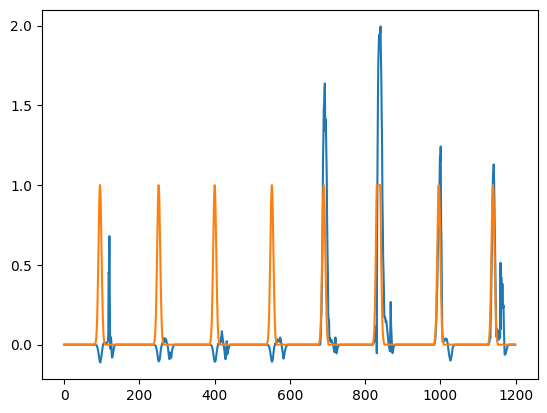

In [146]:
# plt.plot(range(1800), predictions[:, :1][:1800])
plt.plot(range(1200), predictions[:, :1][:1200])
plt.plot(range(1200), actuals[:, :1][:1200])

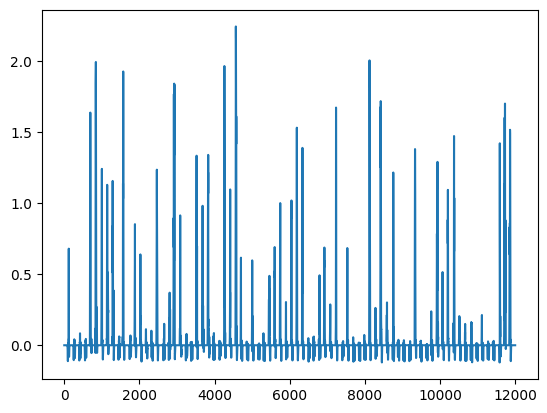

In [144]:
plt.plot(range(12000), predictions[:, :1][:12000])


In [138]:
training.filter(lambda x: (x.group == "010602018"))

TimeSeriesDataSet[length=149](
	time_idx='time_idx',
	target='final_gaussian_target',
	group_ids=['group'],
	weight=None,
	max_encoder_length=30,
	min_encoder_length=30,
	min_prediction_idx=1,
	min_prediction_length=3,
	max_prediction_length=3,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['day_length_seconds'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['ppt', 'tmax', 'tmin', 'tavg'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=True,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
),
	categorical_encoders={'group': NaNLabelEncoder(add_nan=True, warn=True), '__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'day_length_seconds': StandardScaler(), 'ppt': StandardScaler(), 'tmax

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


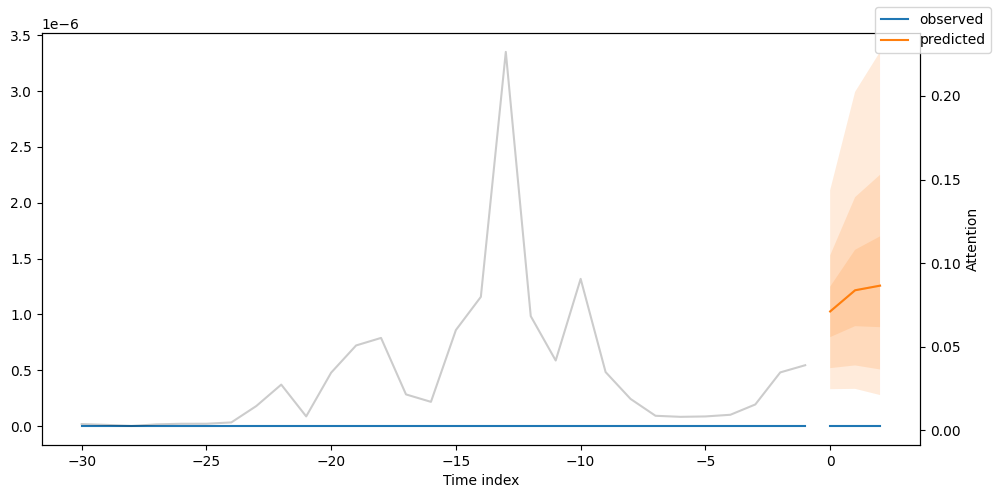

In [139]:
fig, ax = plt.subplots(figsize=(10, 5))
raw_prediction= best_tft.predict(
    training.filter(lambda x: (x.group == "550522020")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, ax=ax);

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x200 with 1 Axes>,
 'encoder_variables': <Figure size 700x325 with 1 Axes>,
 'decoder_variables': <Figure size 700x225 with 1 Axes>}

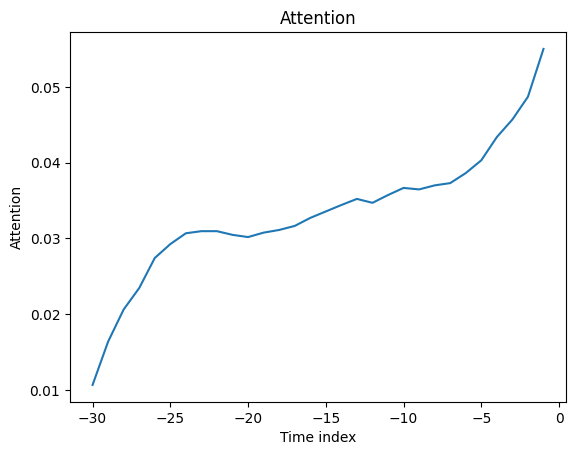

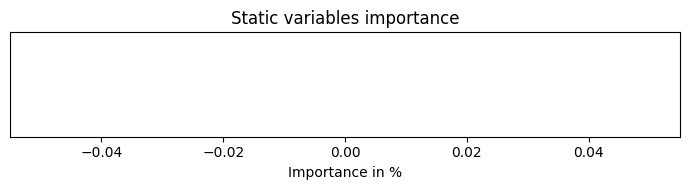

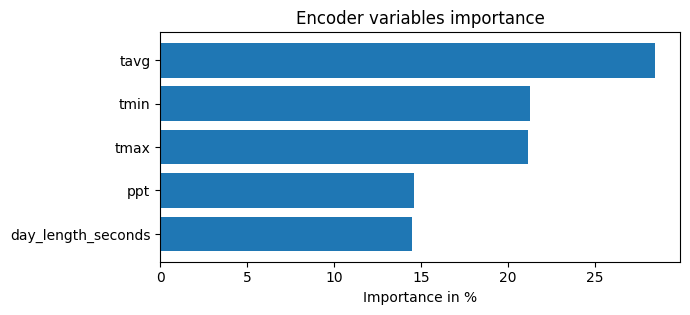

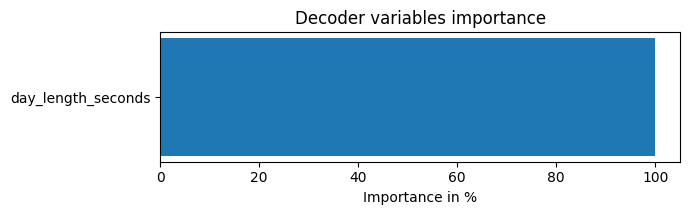

In [141]:
interpretation = best_tft.interpret_output(raw_prediction.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [177]:
total_num_groups = len(training_data.group.unique())

In [178]:
one_half_training_groups = np.random.choice(training_data.group.unique(), round(len(training_data.group.unique()) / 2))

In [179]:
one_tenth_training_groups = np.random.choice(one_half_training_groups, round(len(one_half_training_groups) / 5))

In [185]:
one_one_hundreth_training_groups = np.random.choice(one_tenth_training_groups, round(len(one_tenth_training_groups) / 10))

## How well does the model perform with half as much data? Orders of magnitude less? Would more data help, or is it a lack of other information?

In [186]:
training_data.merge(pd.DataFrame(one_one_hundreth_training_groups, columns=['group']), how='inner', on=['group'])

,group,date_dateobj,time_idx,ppt,tmax,tmin,tavg,day_length_seconds,final_target,final_gaussian_target
0,210442018,2018-01-01,1,0.000,-6.429,-15.087,-10.758,34068.57,0,0.0
1,210442018,2018-01-02,2,0.000,-5.688,-15.001,-10.345,34111.83,0,0.0
2,210442018,2018-01-03,3,0.000,-4.740,-15.489,-10.114,34158.66,0,0.0
3,210442018,2018-01-04,4,1.150,-0.102,-15.427,-7.765,34209.03,0,0.0
4,210442018,2018-01-05,5,0.000,-3.856,-12.906,-8.381,34262.87,0,0.0
...,...,...,...,...,...,...,...,...,...,...
8328,991672022,2022-06-26,177,0.000,25.831,10.484,18.157,57889.00,0,0.0
8329,991672022,2022-06-27,178,0.000,29.091,12.531,20.811,57861.00,0,0.0
8330,991672022,2022-06-28,179,0.000,32.102,13.641,22.872,57828.00,0,0.0
8331,991672022,2022-06-29,180,0.000,28.819,11.064,19.942,57790.00,0,0.0


In [199]:
training_tests = {
    'one_hundreth':one_one_hundreth_training_groups,
    'one_tenth':one_tenth_training_groups,
}

In [200]:
results = {}

In [201]:
for key, group in training_tests.items():
    results[key] = {}
    subset_training_data = training_data.merge(pd.DataFrame(group, columns=['group']), how='inner', on=['group'])    
    subset_training_data = subset_training_data[:-(len(subset_training_data) % batch_size)]
    
    subset_training = TimeSeriesDataSet(
        subset_training_data,
        time_idx="time_idx",
        target="final_gaussian_target",
        group_ids=["group"],
        min_encoder_length=max_encoder_length,  # or adjust according to your data availability
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        time_varying_known_reals=["day_length_seconds"],  # adjust these as per your features
        time_varying_unknown_reals=["ppt", "tmax", "tmin", "tavg"],
        add_relative_time_idx=False,
        add_target_scales=False,
        allow_missing_timesteps=True,
        categorical_encoders={'group': NaNLabelEncoder(add_nan=True)},
    )
    subset_validation = TimeSeriesDataSet.from_dataset(subset_training, validation_data, stop_randomization=True)
    train_dataloader = subset_training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = subset_validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    
    logger = TensorBoardLogger(f"lightning_logs_subset_data_{key}")  
    trainer = pl.Trainer(
        max_epochs=45,
        accelerator="cpu",
        devices=1,
        enable_model_summary=True,
        gradient_clip_val=0.1,
        callbacks=[lr_logger, early_stop_callback],
        logger=logger)

    tft = TemporalFusionTransformer.from_dataset(
        subset_training,
        learning_rate=0.001,
        hidden_size=160,
        attention_head_size=4,
        dropout=0.1,
        hidden_continuous_size=160,
        output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
        loss=QuantileLoss(),
        log_interval=10, 
        reduce_on_plateau_patience=4)

    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader)
    
    results[key]['trainer'] = trainer
    results[key]['tft'] = tft
    results[key]['logger'] = logger
    results[key]['val_dataloader'] = val_dataloader
    results[key]['train_dataloader'] = train_dataloader

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs_subset_data_one_hundreth/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 1.6 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 523 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 103 K 
7  | static_context_v

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.048. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs_subset_data_one_tenth/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 1.6 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 523

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.048. Signaling Trainer to stop.


In [203]:
results['one_hundreth'].trainer.b

{'trainer': <lightning.pytorch.trainer.trainer.Trainer at 0x6714e5870>,
 'tft': TemporalFusionTransformer(
   	"attention_head_size":               4
   	"categorical_groups":                {}
   	"causal_attention":                  True
   	"dropout":                           0.1
   	"embedding_labels":                  {}
   	"embedding_paddings":                ['group']
   	"embedding_sizes":                   {}
   	"hidden_continuous_size":            160
   	"hidden_continuous_sizes":           {}
   	"hidden_size":                       160
   	"learning_rate":                     0.001
   	"log_gradient_flow":                 False
   	"log_interval":                      10
   	"log_val_interval":                  10
   	"lstm_layers":                       1
   	"max_encoder_length":                30
   	"monotone_constaints":               {}
   	"optimizer":                         Ranger
   	"optimizer_params":                  None
   	"output_size":                 

In [207]:
best_model_path_hundredth = results['one_hundreth']['trainer'].checkpoint_callback.best_model_path
best_tft_hundredth = TemporalFusionTransformer.load_from_checkpoint(best_model_path_hundredth)

In [208]:
best_model_path_tenth = results['one_tenth']['trainer'].checkpoint_callback.best_model_path
best_tft_tenth = TemporalFusionTransformer.load_from_checkpoint(best_model_path_tenth)

In [210]:
predictions_hundredth = best_tft_hundredth.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions_hundredth).abs().mean().item())

#average p50 loss per time series
print((actuals - predictions_hundredth).abs().mean(axis=1))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


0.08586227893829346
tensor([1.2058e-07, 1.2053e-07, 1.2001e-07,  ..., 1.0118e+00, 9.8837e-01,
        9.6325e-01])


In [229]:
predictions_hundredth[:180]

tensor([[ 1.1873e-07,  1.2094e-07,  1.2207e-07],
        [ 1.1874e-07,  1.2088e-07,  1.2197e-07],
        [ 1.1817e-07,  1.2035e-07,  1.2149e-07],
        [ 1.1762e-07,  1.1984e-07,  1.2101e-07],
        [ 1.1732e-07,  1.1956e-07,  1.2074e-07],
        [ 1.1658e-07,  1.1882e-07,  1.2004e-07],
        [ 1.1596e-07,  1.1820e-07,  1.1942e-07],
        [ 1.1629e-07,  1.1843e-07,  1.1954e-07],
        [ 1.1616e-07,  1.1825e-07,  1.1931e-07],
        [ 1.1584e-07,  1.1790e-07,  1.1893e-07],
        [ 1.1571e-07,  1.1770e-07,  1.1865e-07],
        [ 1.1544e-07,  1.1736e-07,  1.1825e-07],
        [ 1.1562e-07,  1.1735e-07,  1.1809e-07],
        [ 1.1518e-07,  1.1686e-07,  1.1758e-07],
        [ 1.1473e-07,  1.1637e-07,  1.1705e-07],
        [ 1.1458e-07,  1.1607e-07,  1.1664e-07],
        [ 1.1417e-07,  1.1557e-07,  1.1607e-07],
        [ 1.1398e-07,  1.1520e-07,  1.1557e-07],
        [ 1.1376e-07,  1.1476e-07,  1.1497e-07],
        [ 1.1293e-07,  1.1388e-07,  1.1409e-07],
        [ 1.1202e-07

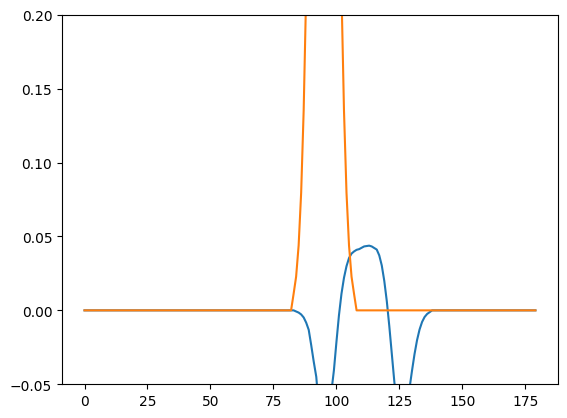

In [242]:
plt.ylim(-0.05, 0.2)
plt.plot(range(180), predictions_hundredth[:, :1][:180])
plt.plot(range(180), actuals[:, :1][:180])

In [211]:
predictions_tenth = best_tft_tenth.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions_tenth).abs().mean().item())

#average p50 loss per time series
print((actuals - predictions_tenth).abs().mean(axis=1))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


0.08255507797002792
tensor([2.1764e-07, 2.1803e-07, 2.1818e-07,  ..., 1.0461e+00, 1.0213e+00,
        9.9800e-01])


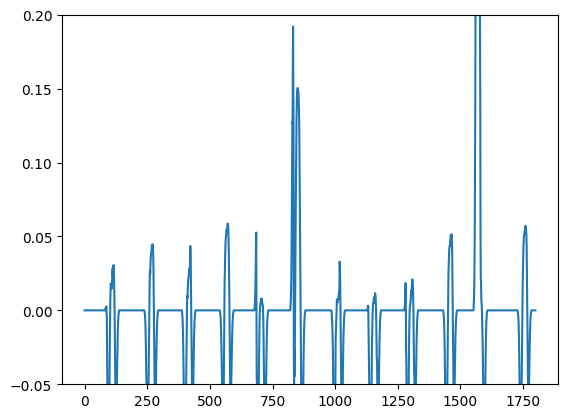

In [244]:
plt.ylim(-0.05, 0.2)

plt.plot(range(1800), predictions_tenth[:, :1][:1800])

In [250]:
raw_prediction_tenth = best_tft_tenth.predict(
    results['one_tenth']['train_dataloader'],
    mode="raw",
    return_x=True,
)

interpretation_tenth = best_tft_tenth.interpret_output(raw_prediction_tenth.output, reduction="sum")
best_tft_tenth.plot_interpretation(interpretation_tenth)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: The expanded size of the tensor (30) must match the existing size (61) at non-singleton dimension 2.  Target sizes: [3, 4, 30].  Tensor sizes: [3, 4, 61]

In [ ]:
raw_prediction_hundredth = best_tft_hundredth.predict(
    results['one_hundreth']['train_dataloader'],
    mode="raw",
    return_x=True,
)

interpretation_hundredth = best_tft_hundredth.interpret_output(raw_prediction_hundredth.output, reduction="sum")
best_tft_hundredth.plot_interpretation(interpretation_hundredth)